In [1]:
import os
os.chdir("../../")

import numpy as np
import pandas as pd
from scripts.utils import *
from scripts.parsing import *
from scripts.evaluate import *

### Chain of Thought

In [150]:
benchmarks = ["SST-2", "CoLA", "AGNews", "MRPC", "SNLI", "WiC"]
models = ['meta-llama/Llama-3-70b-chat-hf', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5-turbo-0125',
          'meta-llama/Llama-3-8b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.2', 'lmsys/vicuna-13b-v1.5', 
          "gpt-4-turbo-2024-04-09"]
tasks = ["batch_clf", "index_selection_one_cat_a_time_json", 
         "index_selection_all_cat_at_once", "index_selection_all_cat_at_once_adjusted"]

In [151]:
prp_df, evaled_df = get_parse_rate_and_performance(benchmarks, models, tasks, return_evaluated_df=True)

In [152]:
task_renamer = {"single_clf": "SingleClf", "batch_clf": "BatchClf", 
                "index_selection_one_cat_a_time_json": "SelectOne", 
                "index_selection_all_cat_at_once_adjusted": "SelectAll"}

model_renamer = {"meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
                 "gpt-3.5-turbo-0125": "GPT-3.5", "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
                 "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", "gpt-4-turbo-2024-04-09": "GPT-4", 
                 "lmsys/vicuna-13b-v1.5": "Vicuna", "random baseline": "Random Baseline"}

prp_df = prp_df.copy()[prp_df.taskSize == 10]
prp_df.task = prp_df.apply(lambda row: "index_selection_all_cat_at_once_adjusted" 
                                  if row.benchmark in ["CoLA", "AGNews"] and 
                                  row.task == "index_selection_all_cat_at_once" 
                                  else row.task, axis=1)
prp_df = prp_df[prp_df.task != "index_selection_all_cat_at_once"]

prp_df.task = prp_df.task.apply(lambda x: task_renamer[x])
prp_df.model = prp_df.model.apply(lambda x: model_renamer[x])
prp_df.task = prp_df.apply(lambda row: row.task + " CoT" if row.CoT else row.task, axis=1)
prp_df.task.value_counts()

BatchClf         42
SelectOne        42
SelectOne CoT    42
SelectAll        42
SelectAll CoT    42
Name: task, dtype: int64

In [9]:
# prp_df[(prp_df.model == "GPT-4") & (prp_df.benchmark != "MRPC")]

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance
13,SST-2,BatchClf,10,GPT-4,False,0,1.0,0.960
48,SST-2,SelectOne,10,GPT-4,False,0,1.0,0.886
55,SST-2,SelectOne CoT,10,GPT-4,True,1,1.0,0.845
125,SST-2,SelectAll,10,GPT-4,False,0,1.0,0.924
132,SST-2,SelectAll CoT,10,GPT-4,True,1,1.0,0.913
167,CoLA,BatchClf,10,GPT-4,False,0,1.0,0.840
202,CoLA,SelectOne,10,GPT-4,False,0,1.0,0.808
209,CoLA,SelectOne CoT,10,GPT-4,True,1,1.0,0.819
244,CoLA,SelectAll,10,GPT-4,False,0,1.0,0.840
272,CoLA,SelectAll CoT,10,GPT-4,True,1,1.0,0.837


In [160]:
def get_overall_results_pv(benchmarks):
    overall_results = []
    cols = ["model", "task", "accuracy"]
    tasks = ["SelectOne", "SelectOne CoT", "SelectAll", "SelectAll CoT", "BatchClf"]

    for task in tasks:
        sub = prp_df.copy()[(prp_df.task == task) & (prp_df.benchmark.isin(benchmarks))]
        overall_results.append(["Overall", task, sub["performance"].mean()])
        
    models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
              "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]
    for model in models:
        sub = prp_df.copy()[(prp_df.model == model) & (prp_df.benchmark.isin(benchmarks))]
        for task in tasks:
            subsub = sub.copy()[sub.task == task]
            acc = subsub["performance"].mean()
            overall_results.append([model, task, acc])

    models = models + ["Overall"]
    overall_results_df = pd.DataFrame(overall_results, columns=cols)
    overall_results_df = overall_results_df.pivot(index="model", columns="task", values="accuracy")
    overall_results_df = overall_results_df.loc[models]
    overall_results_df = overall_results_df.round(3)
    overall_results_df = overall_results_df * 100
    overall_results_df = overall_results_df.astype(float)
    return overall_results_df[tasks]

In [161]:
overall_results_df = get_overall_results_pv(benchmarks).dropna()
overall_results_df

task,SelectOne,SelectOne CoT,SelectAll,SelectAll CoT,BatchClf
model,,,,,
Vicuna,23.0,25.8,53.2,57.6,68.7
Mistral 7B,38.3,47.5,56.8,60.5,71.2
Mixtral 8x7B,47.4,38.7,65.1,58.4,73.4
Llama-3 8B,39.0,41.8,62.4,59.0,73.3
Llama-3 70B,59.4,67.1,72.9,79.2,79.4
GPT-3.5,45.5,47.5,66.7,66.3,71.9
GPT-4,66.3,71.8,78.8,81.8,81.9
Overall,45.5,48.6,65.1,66.1,74.3


In [162]:
print(overall_results_df.to_latex(escape=False))

\begin{tabular}{lrrrrr}
\toprule
task &  SelectOne &  SelectOne CoT &  SelectAll &  SelectAll CoT &  BatchClf \\
model        &            &                &            &                &           \\
\midrule
Vicuna       &       23.0 &           25.8 &       53.2 &           57.6 &      68.7 \\
Mistral 7B   &       38.3 &           47.5 &       56.8 &           60.5 &      71.2 \\
Mixtral 8x7B &       47.4 &           38.7 &       65.1 &           58.4 &      73.4 \\
Llama-3 8B   &       39.0 &           41.8 &       62.4 &           59.0 &      73.3 \\
Llama-3 70B  &       59.4 &           67.1 &       72.9 &           79.2 &      79.4 \\
GPT-3.5      &       45.5 &           47.5 &       66.7 &           66.3 &      71.9 \\
GPT-4        &       66.3 &           71.8 &       78.8 &           81.8 &      81.9 \\
Overall      &       45.5 &           48.6 &       65.1 &           66.1 &      74.3 \\
\bottomrule
\end{tabular}



/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_34485/2418006672.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(overall_results_df.to_latex(escape=False))


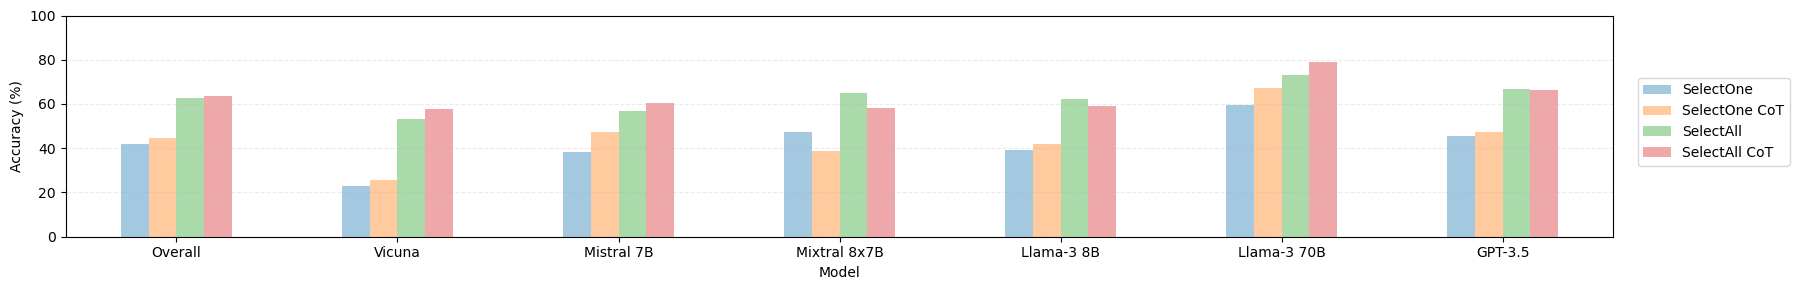

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 3))
overall_results_df.plot(kind='bar', ax=ax, alpha=0.4)
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.ylim(0, 100)
plt.legend(loc='upper center', bbox_to_anchor=(1.065, 0.75))
plt.tight_layout()
# plt.savefig("plots/1-shot-cot-results.png", dpi=300)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 3))

In [136]:
prp_df.head()

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance
7,SST-2,BatchClf,10,Llama-3 70B,False,0,1.0,0.964
8,SST-2,BatchClf,10,Mixtral 8x7B,False,0,1.0,0.802
9,SST-2,BatchClf,10,GPT-3.5,False,0,1.0,0.950
10,SST-2,BatchClf,10,Llama-3 8B,False,0,1.0,0.920
11,SST-2,BatchClf,10,Mistral 7B,False,0,1.0,0.796


In [139]:
benchmarks = ['SST-2', 'CoLA', 'AGNews', 'MRPC', 'SNLI', 'WiC']
benchmarks

['SST-2', 'CoLA', 'AGNews', 'MRPC', 'SNLI', 'WiC']

In [171]:
models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4", "Overall"]

In [176]:
tasks = ["SelectOne", "SelectOne CoT", "SelectAll", "SelectAll CoT", "BatchClf"]

In [178]:
overall = []

for benchmark in benchmarks:
    for task in ["SelectOne", "SelectOne CoT", "SelectAll", "SelectAll CoT", "BatchClf"]:
        sub = prp_df.copy()[(prp_df.benchmark == benchmark) & (prp_df.task == task)]
        overall.append([benchmark, task, 10, "Overall", "-", "-", "-", sub["performance"].mean()])

prp_df_ = prp_df.append(pd.DataFrame(overall, columns=prp_df.columns))
t = prp_df_.pivot(index=["model", "task"], columns="benchmark", values="performance")[benchmarks]
t = t.round(3) * 100
print(t.reindex(models, level=0).reindex(tasks, level=1).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
        & benchmark &  SST-2 &  CoLA &  AGNews &  MRPC &  SNLI &   WiC \\
model & task &        &       &         &       &       &       \\
\midrule
Vicuna & SelectOne &   38.5 &  22.2 &    16.8 &  15.8 &   9.9 &  34.5 \\
        & SelectOne CoT &   52.6 &  53.9 &    12.1 &  12.1 &  11.5 &  12.5 \\
        & SelectAll &   66.7 &  65.7 &    42.2 &  67.4 &  28.2 &  48.8 \\
        & SelectAll CoT &   81.7 &  69.2 &    40.9 &  63.9 &  40.9 &  48.9 \\
        & BatchClf &   89.1 &  73.2 &    70.4 &  66.7 &  59.3 &  53.4 \\
Mistral 7B & SelectOne &   53.3 &  52.8 &    41.5 &  36.6 &  23.3 &  22.2 \\
        & SelectOne CoT &   66.5 &  55.1 &    44.8 &  59.4 &  29.5 &  29.5 \\
        & SelectAll &   68.3 &  63.6 &    48.2 &  58.4 &  54.7 &  47.9 \\
        & SelectAll CoT &   74.4 &  68.2 &    57.0 &  68.5 &  47.6 &  47.3 \\
        & BatchClf &   79.6 &  76.8 &    78.1 &  74.0 &  69.1 &  49.6 \\
Mixtral 8x7B & SelectOne &   76.5 &  61.0 &    46.2 &  45.2

/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_34485/3031338587.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prp_df_ = prp_df.append(pd.DataFrame(overall, columns=prp_df.columns))
/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_34485/3031338587.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(t.reindex(models, level=0).reindex(tasks, level=1).to_latex())


### Reasoning

In [10]:
import re
from scripts.evaluate import answer_cleansing

def get_preds(pred, qsize=2):  
    if not pred:
        return False
    
    if isinstance(pred, str):
        pred = pred.strip()
        if len(pred) == 0:
            return False

    preds = []
    if pred[0] == ":" and len(pred) > 1:
        pred = pred[1:]
    
    if len(pred.split("\n\n")) == qsize:
        preds = pred.split("\n\n")
    
    elif len(pred.split("\n")) == qsize:
        preds = pred.split("\n")

    elif len(re.split(r"[QA]\d+: ?", pred)[1:]) == qsize:
        preds = re.split(r"[QA]\d+: ?", pred)[1:]
    
    if len(preds) != qsize:
        return False
    
    preds = [re.sub(r"[AQ]\d*:", "", p).strip() for p in preds]
    preds = [re.sub(r"Answer:", "", p, flags=re.I).strip() for p in preds]
    return preds

In [11]:
def safe_convert_to(dtype):
    def convert_to(value):
        try:
            return dtype(value)
        except:
            return value
    return convert_to

In [12]:
import os

reasoning_benchmarks = [d for d in os.listdir("results/reasoning") if d not in [".DS_Store", "mixed"]]
reasoning_benchmarks

['commonsensqa',
 'strategyqa',
 'object_tracking',
 'last_letters',
 'coin_flip',
 'svamp',
 'bigbench_date',
 'gsm8k',
 'aqua',
 'singleeq',
 'addsub',
 'multiarith']

In [13]:
def read_reasoning_benchmark_results(benchmark, multi_question=False, 
                                     method="zero-shot"):
    if multi_question:
        input_fp = f"results/reasoning/{benchmark}/multiple question/{method}.json"
        df = pd.read_json(input_fp)
    else:
        input_fp = f"results/reasoning/{benchmark}/single question/{method}.csv"
        df = pd.read_csv(input_fp)
        df.insert(0, "promptIdx", df.index + 1)
        df.insert(2, "qsize", 1)
    return df

In [14]:
d = "commonsensqa"
df = read_reasoning_benchmark_results(d, False)
df.columns

Index(['promptIdx', 'prompt', 'qsize', 'answer',
       'gpt-3.5-turbo-0125-completion',
       'meta-llama/Llama-3-70b-chat-hf-completion',
       'mistralai/Mistral-7B-Instruct-v0.2-completion',
       'mistralai/Mixtral-8x7B-Instruct-v0.1-completion',
       'lmsys/vicuna-13b-v1.5-completion',
       'meta-llama/Llama-3-8b-chat-hf-completion',
       'gpt-4-turbo-2024-04-09-completion'],
      dtype='object')

In [15]:
r_models = ['meta-llama/Llama-3-8b-chat-hf', 'meta-llama/Llama-3-70b-chat-hf', 
            'mistralai/Mistral-7B-Instruct-v0.2', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 
            'lmsys/vicuna-13b-v1.5', 'gpt-3.5-turbo-0125']

def parse(pred, model, dataset):
    method = "zero-shot"
    trigger = "answer is"

    if "llama" in model:
        method = "few-shot"
    elif "mistralai" in model:
        if dataset in ["last_letters", "svamp", "gsm8k", "aqua", "singleeq", "addsub", "multiarith"]:
            method = "few-shot"
    elif model == "gpt-3.5-turbo-0125":
        if dataset == "gsm8k":
            method = "few-shot"
    elif model == "lmsys/vicuna-13b-v1.5":
        if dataset in ["svamp", "gsm8k", "aqua", "singleeq", "addsub", "multiarith"]:
            method = "few-shot"
    
    # sign of reasoning!
    if "=" in pred and ("+" in pred or "-" in pred or "*" in pred or "/" in pred):
        method = "few-shot"

    pred = answer_cleansing(pred, method, dataset, trigger)
    
    if pred == "":
        return "CANNOT_PARSE"
    return pred


parsed_results = []
cols = ["benchmark", "promptIdx", "prompt", "answer", "#shot", "CoT", 
        "qsize", "model", "completion", "parsed", "perTaskAccu"]

for benchmark in reasoning_benchmarks:
    for multi_question in [False, True]:
        df = read_reasoning_benchmark_results(benchmark, multi_question)
        
        for idx, row in df.iterrows():
            promptIdx = row["promptIdx"]
            prompt = row["prompt"]
            answer = row["answer"]
            qsize = row["qsize"]

            for model in r_models:
                completion = row[f"{model}-completion"]

                try:
                    if qsize == 1:
                        parsed = parse(completion, model, benchmark)

                        if benchmark in ("gsm8k", "addsub", "multiarith", "svamp", "singleeq"):
                            parsed = safe_convert_to(float)(parsed)
                            answer = safe_convert_to(float)(answer)
                        
                        accu = float(parsed == answer)
                    
                    else:
                        preds = get_preds(completion, qsize)
                        if not preds:
                            parsed = "CANNOT_PARSE"
                            accu = 0.0
                        else:
                            parsed = [parse(p, model, benchmark) for p in preds]

                            if benchmark in ("gsm8k", "addsub", "multiarith", "svamp", "singleeq"):
                                parsed = [safe_convert_to(float)(p) for p in parsed]
                                answer = [safe_convert_to(float)(a) for a in answer]

                            accu = sum([float(a==p) for a, p in zip(answer, parsed)]) / qsize

                except Exception as e:
                    print(benchmark, model, promptIdx, qsize, e)
                    parsed = "CANNOT_PARSE"
                    accu = 0.0
                
                parsed_results.append([benchmark, promptIdx, prompt, answer, 0, False, 
                                       qsize, model, completion, parsed, accu])

commonsensqa mistralai/Mixtral-8x7B-Instruct-v0.1 895 1 argument of type 'float' is not iterable


In [16]:
model_renamer = {"meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
                "gpt-3.5-turbo-0125": "GPT-3.5", "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
                "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", "gpt-4-turbo-2024-04-09": "GPT-4", 
                "lmsys/vicuna-13b-v1.5": "Vicuna 13B"}

In [17]:
cols = ["benchmark", "promptIdx", "prompt", "answer", "#shot", "CoT", 
        "qsize", "model", "completion", "parsed", "perTaskAccu"]

parsed_df = pd.DataFrame(parsed_results, columns=cols)
parsed_df.model = parsed_df.model.apply(lambda x: model_renamer[x])
parsed_df.head()

,benchmark,promptIdx,prompt,answer,#shot,CoT,qsize,model,completion,parsed,perTaskAccu
0,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Llama-3 8B,A clever question!\n\nThe correct answer is (E...,E,1.0
1,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Llama-3 70B,The correct answer is (E) dark.\n\nCandles are...,E,1.0
2,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Mistral 7B,(E) dark. Candles are commonly used to provid...,E,1.0
3,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Mixtral 8x7B,E: dark. Candles produce light and help to el...,E,1.0
4,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Vicuna 13B,(E) dark.\n\nCandles are often used to provid...,E,1.0


In [18]:
accu_df = []
cols = ["benchmark", "model", "method", "qsize", "accuracy"]

parsed_df_filtered = parsed_df.copy()[parsed_df.parsed != "CANNOT_PARSE"]

for benchmark in parsed_df_filtered.benchmark.unique():
    sub = parsed_df_filtered.copy()[parsed_df_filtered.benchmark == benchmark]
    for model in parsed_df_filtered.model.unique():
        subsub = sub.copy()[sub.model == model]

        for qsize in parsed_df_filtered.qsize.unique():
            subsubsub = subsub.copy()[subsub.qsize == qsize]
            accu = subsubsub["perTaskAccu"].mean()
            accu_df.append([benchmark, model, "zero-shot", qsize, accu])

accu_df = pd.DataFrame(accu_df, columns=cols)
# accu_df = accu_df.pivot(index="model", columns="qsize", values="accuracy")
accu_df.shape

(288, 5)

In [19]:
accu_df

,benchmark,model,method,qsize,accuracy
0,commonsensqa,Llama-3 8B,zero-shot,1,0.759624
1,commonsensqa,Llama-3 8B,zero-shot,2,0.657627
2,commonsensqa,Llama-3 8B,zero-shot,5,0.731058
3,commonsensqa,Llama-3 8B,zero-shot,10,0.727458
4,commonsensqa,Llama-3 70B,zero-shot,1,0.818333
...,...,...,...,...,...
283,multiarith,Vicuna 13B,zero-shot,10,0.393878
284,multiarith,GPT-3.5,zero-shot,1,0.821667
285,multiarith,GPT-3.5,zero-shot,2,0.802676
286,multiarith,GPT-3.5,zero-shot,5,0.833333


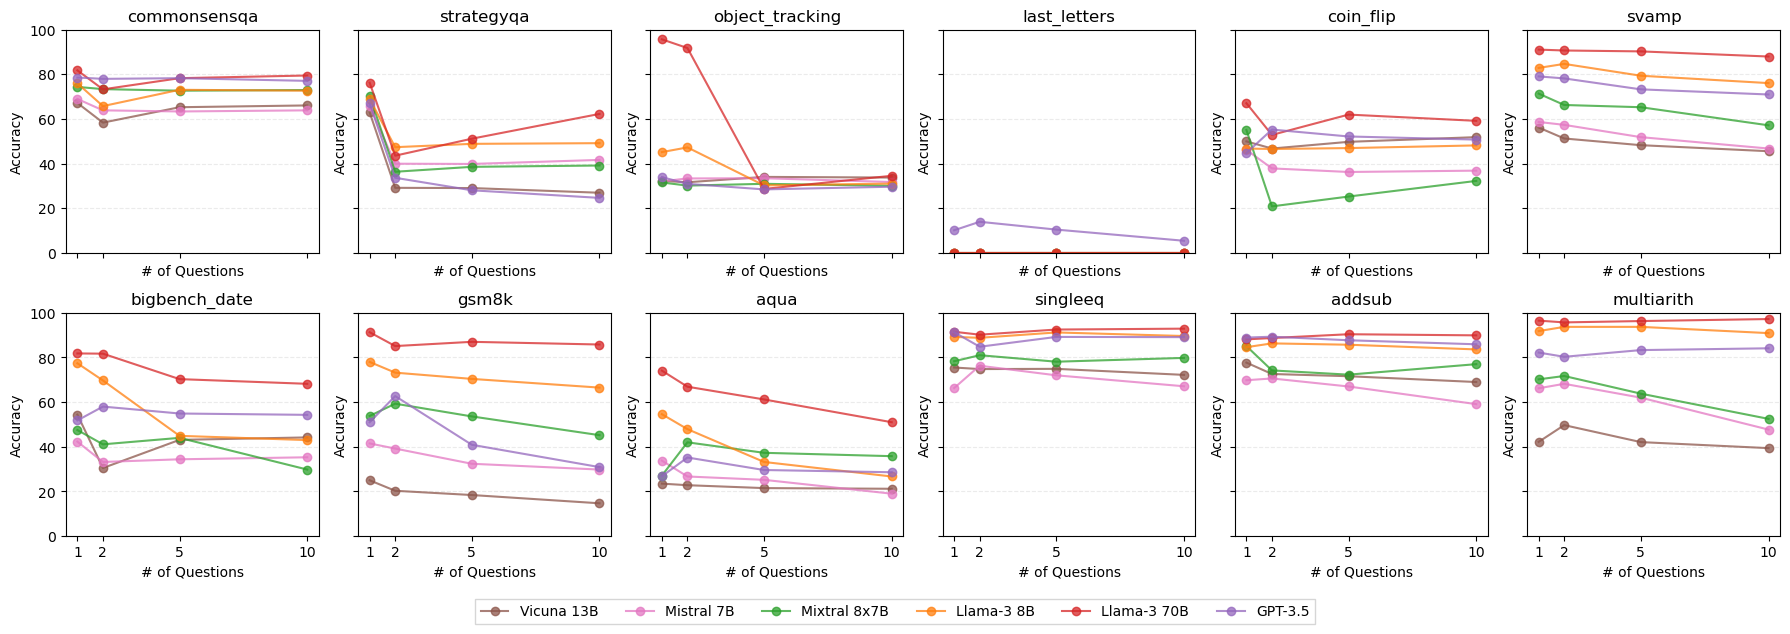

In [20]:
import matplotlib.pyplot as plt

models = ["Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5"]

colors = ["tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]


colorMap = dict(zip(models, colors))

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharex=True, sharey=True)

for i, benchmark in enumerate(reasoning_benchmarks):
    sub = accu_df.copy()[accu_df.benchmark == benchmark]
    ax = axes[i//6, i%6]

    for model in models:
        accus = []
        subsub = sub.copy()[sub.model == model]
        qsizes = sorted(subsub.qsize.unique())

        for qsize in qsizes:
            accu = subsub[subsub.qsize == qsize]["accuracy"].values[0]
            accus.append(round(accu, 3) * 100)
        
        ax.plot(qsizes, accus, label=model, color=colorMap[model], 
                marker='o', linestyle='-', alpha=0.75)
        
        ax.set_title(benchmark)
        ax.set_xlabel("# of Questions")
        ax.set_xticks(qsizes)
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0, 100)
        ax.grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-2.5, -0.25), fancybox=False, shadow=False, ncol=6)
# plt.savefig("plots/reasoning-results.png", bbox_inches='tight', dpi=300)
plt.show()

In [158]:
# parsed_df[(parsed_df.benchmark == "object_tracking") & (parsed_df.model == "Llama-3 70B")].sample(10)

In [21]:
# visualize accu_df in both model-wise and benchmark-wise manner across qsize

def get_overall_results_pv(benchmarks):
    overall_results = []
    cols = ["model", "qsize", "accuracy"]

    models = ["Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
              "Llama-3 8B", "Llama-3 70B", "GPT-3.5"]
    for model in models:
        for qsize in [1, 2, 5, 10]:
            sub = accu_df.copy()[(accu_df.model == model) & (accu_df.benchmark.isin(benchmarks)) & (accu_df.qsize == qsize)]
            acc = sub["accuracy"].mean()
            overall_results.append([model, qsize, acc])

    models = models
    overall_results_df = pd.DataFrame(overall_results, columns=cols)
    overall_results_df = overall_results_df.pivot(index="model", columns="qsize", values="accuracy")
    overall_results_df = overall_results_df.loc[models]
    overall_results_df = overall_results_df.round(3)
    overall_results_df = overall_results_df * 100
    overall_results_df = overall_results_df.astype(float)
    return overall_results_df

In [27]:
reasoning_benchmarks

['commonsensqa',
 'strategyqa',
 'object_tracking',
 'last_letters',
 'coin_flip',
 'svamp',
 'bigbench_date',
 'gsm8k',
 'aqua',
 'singleeq',
 'addsub',
 'multiarith']

In [25]:
select_benchmarks = ['commonsensqa','strategyqa', 'object_tracking', 
                     'coin_flip', 'svamp', 'bigbench_date', 'gsm8k', 'aqua', 
                     'singleeq', 'addsub', 'multiarith']

In [43]:
overall_reasoning_results = get_overall_results_pv(select_benchmarks)
overall_reasoning_results

qsize,1,2,5,10
model,,,,
Vicuna 13B,51.6,44.4,45.3,44.1
Mistral 7B,53.8,49.7,47.1,43.6
Mixtral 8x7B,60.5,54.2,52.9,50.2
Llama-3 8B,72.3,68.3,63.4,61.6
Llama-3 70B,85.0,78.2,73.5,73.5
GPT-3.5,63.2,62.4,58.7,56.9


In [44]:
overall_reasoning_results.to_numpy().mean(axis=0).round(1)

array([64.4, 59.5, 56.8, 55. ])

In [46]:
overall_reasoning_results.to_numpy()[:, 1:].mean().round(1)

57.1

In [47]:
(64.4 - 57.1) / 64.4

0.1133540372670808

In [42]:
(59.2 - 52.5) / 59.2

0.11317567567567571

In [138]:
# pd.set_option('display.max_colwidth', 500)

# parsed_df[(parsed_df.qsize == 2) & (parsed_df.benchmark != "last_letters")].sample(10)[
#     ["benchmark", "model", "qsize", "answer", "parsed", "perTaskAccu", "completion"]]

In [128]:
parsed_df[(parsed_df.model == "mistralai/Mistral-7B-Instruct-v0.2") & 
          (parsed_df.parsed == "CANNOT_PARSE")].benchmark.value_counts()

strategyqa         478
aqua               149
coin_flip          112
bigbench_date       76
commonsensqa        65
last_letters        43
svamp               13
gsm8k               12
object_tracking      8
addsub               3
singleeq             2
multiarith           2
Name: benchmark, dtype: int64

In [126]:
parsed_df[(parsed_df.parsed == "CANNOT_PARSE") & (parsed_df.benchmark != "last_letters")].model.value_counts()

mistralai/Mistral-7B-Instruct-v0.2      920
mistralai/Mixtral-8x7B-Instruct-v0.1    771
meta-llama/Llama-3-70b-chat-hf          443
meta-llama/Llama-3-8b-chat-hf           325
lmsys/vicuna-13b-v1.5                   218
gpt-3.5-turbo-0125                       66
Name: model, dtype: int64

In [116]:
# pd.set_option('display.max_rows', 100)
# parsed_df[parsed_df.parsed == "CANNOT_PARSE"].groupby(["model"]).benchmark.value_counts()

In [115]:
# r_models = ['meta-llama/Llama-3-8b-chat-hf', 'meta-llama/Llama-3-70b-chat-hf', 
#             'mistralai/Mistral-7B-Instruct-v0.2', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 
#             'lmsys/vicuna-13b-v1.5', 'gpt-3.5-turbo-0125']

# r_models = ['meta-llama/Llama-3-8b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.2', 'gpt-3.5-turbo-0125', 'lmsys/vicuna-13b-v1.5'][:1]


# for d in reasoning_benchmarks:

#     df = read_reasoning_benchmark_results(d, True)

#     print(f"{'='*50} Benchmark: {d} {'='*50}" + "\n\n")
    
#     indices = df.sample(10).index
#     for model in r_models:    
#         print(f"{'='*50} Model: {model} {'='*50}")
#         for idx in indices:
#             print(f"{'-'*50} Prompt Index: {idx} {'-'*50}")
#             # prompt = df.at[idx, "prompt"]
#             # print(f"Prompt: {prompt}")
#             pred = df.at[idx, f"{model}-completion"]
#             qsize = df.at[idx, "qsize"]

#             print(f"Qsize: {qsize}")
#             print(f"Completion: {pred}")

#             pred = get_preds(pred, qsize=qsize)

#             if pred:
#                 # print(f"Qsize: {qsize}")
#                 # print(f"Completion: {pred}")
#                 parsed = "; ".join([parse(p, model, d) for p in pred])
#                 print(f"Cleaned Prediction: {parsed}")

#                 ans = df.at[idx, "answer"]
#                 print(f"Answer: {ans}")
#                 print(f"{'-'*50} {'-'*50}")
#         print(f"{'='*50} {'='*50}" + "\n\n")

### Simple index selection

In [97]:
benchmarks = ["AGNews", "AGNews-simplified_index_selection_only"]
models = ['meta-llama/Llama-3-70b-chat-hf', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5-turbo-0125',
          'meta-llama/Llama-3-8b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.2', 'gpt-4-turbo-2024-04-09', 'lmsys/vicuna-13b-v1.5']
tasks = ["batch_clf", "index_selection_one_cat_a_time", "index_selection_all_cat_at_once"]

prp_df_2, evaled_df_2 = get_parse_rate_and_performance(benchmarks, models, tasks, return_evaluated_df=True)

In [98]:
prp_df_2

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance
0,AGNews,batch_clf,5,meta-llama/Llama-3-70b-chat-hf,False,0,1.0,0.8840
1,AGNews,batch_clf,5,mistralai/Mixtral-8x7B-Instruct-v0.1,False,0,1.0,0.7560
2,AGNews,batch_clf,5,gpt-3.5-turbo-0125,False,0,1.0,0.8500
3,AGNews,batch_clf,5,meta-llama/Llama-3-8b-chat-hf,False,0,1.0,0.7520
4,AGNews,batch_clf,5,mistralai/Mistral-7B-Instruct-v0.2,False,0,1.0,0.7800
...,...,...,...,...,...,...,...,...
170,AGNews-simplified_index_selection_only,index_selection_all_cat_at_once,100,gpt-3.5-turbo-0125,False,0,1.0,0.8972
171,AGNews-simplified_index_selection_only,index_selection_all_cat_at_once,100,meta-llama/Llama-3-8b-chat-hf,False,0,1.0,0.4627
172,AGNews-simplified_index_selection_only,index_selection_all_cat_at_once,100,mistralai/Mistral-7B-Instruct-v0.2,False,0,1.0,0.3460
173,AGNews-simplified_index_selection_only,index_selection_all_cat_at_once,100,gpt-4-turbo-2024-04-09,False,0,1.0,0.9917


In [99]:
prp_df_2 = prp_df_2.copy()[~((prp_df_2.benchmark == "SST-2") & (prp_df_2.task == "index_selection_all_cat_at_once"))]
prp_df_2 = prp_df_2.copy()[~((prp_df_2.model == "lmsys/vicuna-13b-v1.5") & (prp_df_2.taskSize==100))]
# prp_df[prp_df.benchmark.isin(["SST-2", "CoLA"])].task.value_counts()

In [100]:
model_renamer = {"meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
                 "gpt-3.5-turbo-0125": "GPT-3.5", "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
                 "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", "gpt-4-turbo-2024-04-09": "GPT-4", 
                 "lmsys/vicuna-13b-v1.5": "Vicuna", "random baseline": "Random Baseline"}

task_renamer = {"single_clf": "SingleClf", "batch_clf": "BatchClf", 
                "index_selection_one_cat_a_time": "SelectOne",
                "index_selection_one_cat_a_time_json": "SelectOne", 
                "index_selection_all_cat_at_once": "SelectAll",
                "index_selection_all_cat_at_once_adjusted": "SelectAll"}

prp_df_2.model = prp_df_2.model.map(model_renamer)
prp_df_2.task = prp_df_2.task.map(task_renamer)
prp_df_2.benchmark = prp_df_2.benchmark.map({"AGNews": "AGNews", "AGNews-simplified_index_selection_only": "AGNews (Simplified)"})

In [101]:
prp_df_2.model.value_counts()

Llama-3 70B     25
Mixtral 8x7B    25
GPT-3.5         25
Llama-3 8B      25
Mistral 7B      25
GPT-4           25
Vicuna          20
Name: model, dtype: int64

In [102]:
prp_df_2.task.value_counts()

SelectOne    68
SelectAll    68
BatchClf     34
Name: task, dtype: int64

In [103]:
prp_df_2

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance
0,AGNews,BatchClf,5,Llama-3 70B,False,0,1.0,0.8840
1,AGNews,BatchClf,5,Mixtral 8x7B,False,0,1.0,0.7560
2,AGNews,BatchClf,5,GPT-3.5,False,0,1.0,0.8500
3,AGNews,BatchClf,5,Llama-3 8B,False,0,1.0,0.7520
4,AGNews,BatchClf,5,Mistral 7B,False,0,1.0,0.7800
...,...,...,...,...,...,...,...,...
169,AGNews (Simplified),SelectAll,100,Mixtral 8x7B,False,0,1.0,0.8532
170,AGNews (Simplified),SelectAll,100,GPT-3.5,False,0,1.0,0.8972
171,AGNews (Simplified),SelectAll,100,Llama-3 8B,False,0,1.0,0.4627
172,AGNews (Simplified),SelectAll,100,Mistral 7B,False,0,1.0,0.3460


In [104]:
main_results = []
cols = ["benchmark", "task", "taskSize", "accuracy"]
tasks = ["BatchClf", "SelectOne", "SelectAll"]
benchmarks = ["AGNews", "AGNews (Simplified)"]

for benchmark in benchmarks:
    sub = prp_df_2.copy()[prp_df_2.benchmark == benchmark]
    for task in tasks:
        subsub = sub.copy()[sub.task == task]
        for taskSize in sorted(subsub.taskSize.unique()):
            subsubsub = subsub.copy()[subsub.taskSize == taskSize]
            acc = subsubsub["performance"].mean()
            main_results.append([benchmark, task, taskSize, acc])

# benchmarks = names[:1] + names[-1:] + benchmarks[:3] + benchmarks[3:]
main_results_df = pd.DataFrame(main_results, columns=cols)
main_results_df_pv = main_results_df.pivot(index=["benchmark", "taskSize"], columns="task", values="accuracy")
main_results_df_pv = main_results_df_pv.loc[benchmarks]
main_results_df_pv = main_results_df_pv.round(3)
main_results_df_pv = main_results_df_pv * 100
main_results_df_pv = main_results_df_pv.astype(float)
main_results_df_pv[tasks]

task                          BatchClf  SelectOne  SelectAll
benchmark           taskSize                                
AGNews              5             79.3       43.8       60.5
                    10            79.9       43.2       62.4
                    20            77.2       39.0       57.3
                    50            73.5       30.1       42.3
                    100           71.5       26.9       35.2
AGNews (Simplified) 5              NaN       79.1       78.0
                    10             NaN       83.1       87.3
                    20             NaN       86.1       89.6
                    50             NaN       78.7       79.6
                    100            NaN       82.7       75.7

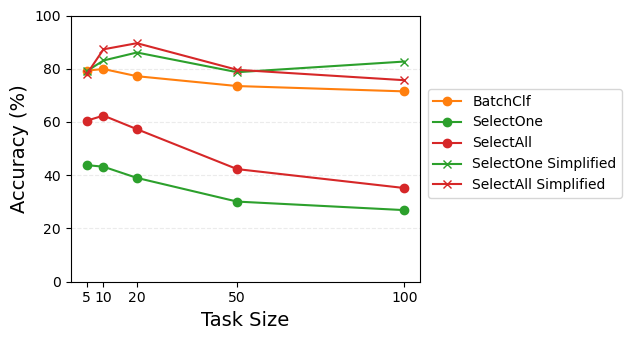

In [134]:
import matplotlib.pyplot as plt

task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
              "SelectOne": "tab:green", "SelectAll": "tab:red"}

plt.figure(figsize=(7, 3.5))

for benchmark in benchmarks:
    for task in tasks:
        sub = main_results_df.copy()[(main_results_df.benchmark == benchmark) & (main_results_df.task == task)]

        if len(sub) == 0:
            continue

        taskSizes = sorted(sub.taskSize.unique())

        accus = []
        for taskSize in taskSizes:
            subsub = sub.copy()[sub.taskSize == taskSize]
            acc = subsub["accuracy"].values[0]
            accus.append(round(acc, 3) * 100)
        
        if "Simplified" in benchmark:
            suffix = " Simplified"
            marker = 'x'
        else:
            suffix = ""
            marker = 'o'
        plt.plot(taskSizes, accus, label=task+suffix, marker=marker, color=task2color[task])

plt.ylim(0, 100)
plt.xticks(taskSizes)
plt.xlabel("Task Size", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.75))
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig("plots/simplified-index-selection-results.png", dpi=300)
plt.show()

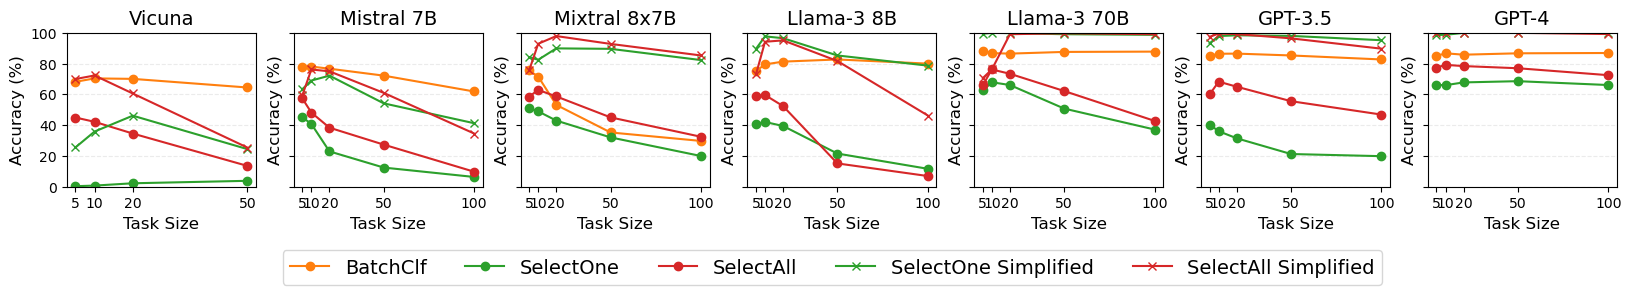

In [61]:
models = ['Vicuna', 'Mistral 7B', 'Mixtral 8x7B', 'Llama-3 8B', 'Llama-3 70B', 'GPT-3.5', "GPT-4"]
fig, axs = plt.subplots(1, 7, figsize=(20, 2), sharey=True)

for i, model in enumerate(models):
    ax = axs[i]

    for benchmark in benchmarks:
        for task in tasks:
            sub = prp_df_2.copy()[(prp_df_2.model == model) & 
                                  (prp_df_2.task == task) & 
                                  (prp_df_2.benchmark == benchmark)]
        
            if len(sub) == 0:
                continue

            taskSizes = sorted(sub.taskSize.unique())
            accus = []
            for taskSize in taskSizes:
                subsub = sub.copy()[sub.taskSize == taskSize]
                acc = subsub["performance"].mean()
                accus.append(round(acc, 3) * 100)
            
            if "Simplified" in benchmark:
                suffix = " Simplified"
                marker = 'x'
            else:
                suffix = ""
                marker = 'o'
            ax.plot(taskSizes, accus, label=task+suffix, marker=marker, color=task2color[task])
            ax.set_title(model, fontsize=14)
            ax.set_ylim(0, 100)
            ax.set_xticks(taskSizes)
            ax.set_xlabel("Task Size", fontsize=12)
            ax.set_ylabel("Accuracy (%)", fontsize=12)         
            ax.grid(axis='y', linestyle='--', alpha=0.25)
               
plt.legend(loc='upper center', bbox_to_anchor=(-3.15, -0.35), ncol=5, fontsize=14)
# plt.tight_layout()
plt.savefig("plots/simplified-index-selection-full-results.png", bbox_inches='tight', dpi=300)
plt.show()

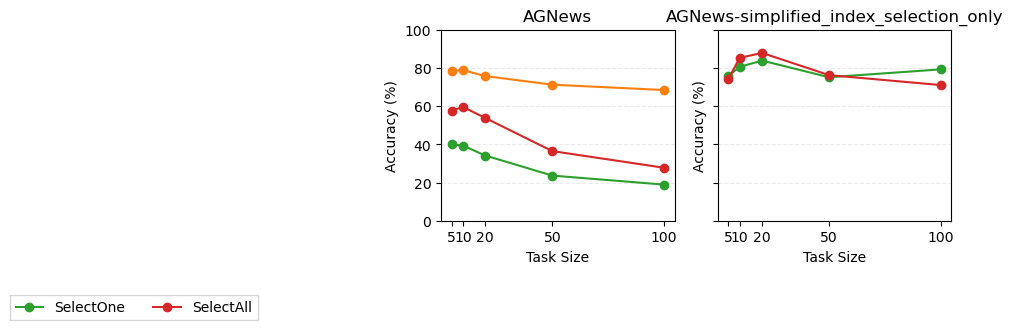

In [106]:
# import matplotlib.pyplot as plt

# # make a 1x6 grid plots, where each panel is a benchmark, with the taskSize on the x-axis and accuracy on the y-axis.

# task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
#               "SelectOne": "tab:green", "SelectAll": "tab:red"}

# fig, axs = plt.subplots(1, len(benchmarks), figsize=(6, 3), sharey=True)
# for i, benchmark in enumerate(benchmarks):
#     sub = main_results_df[main_results_df.benchmark == benchmark]

#     if "AGNews" not in benchmark:
#         taskSizes = sorted(sub.taskSize.unique())[1:]
#     else:
#         taskSizes = sorted(sub.taskSize.unique())
    
#     for task in tasks:
#         subsub = sub[sub.task == task]

#         if task == "SingleClf":
#             acc = subsub.accuracy
#             axs[i].plot(taskSizes, [round(acc, 3) * 100] * len(taskSizes), label=task, linestyle="--", color=task2color[task])
#             axs[i].plot(taskSizes, [round(acc * 0.90, 3) * 100] * len(taskSizes), label=f"90% {task} Acc", 
#                         linestyle="--", color=task2color[task], alpha=0.75)
#             axs[i].plot(taskSizes, [round(acc * 0.80, 3) * 100] * len(taskSizes), label=f"80% {task} Acc", 
#                         linestyle="--", color=task2color[task], alpha=0.5)
            
#             axs[i].plot(taskSizes, [round(acc * 0.75, 3) * 100] * len(taskSizes), label=f"75% {task} Acc", 
#                         linestyle="--", color=task2color[task], alpha=0.22)

#         else:
#             accs = []
#             for taskSize in taskSizes:
#                 acc = subsub[subsub.taskSize == taskSize].accuracy
#                 accs.append(round(acc, 3) * 100)
                
#             axs[i].plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])
        
#         axs[i].set_title(benchmark)
#         axs[i].set_xlabel("Task Size")
#         axs[i].set_xticks(taskSizes)
#         axs[i].set_ylabel("Accuracy (%)")
#         axs[i].grid(axis='y', linestyle='--', alpha=0.25)
#         # axs[i].legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
#         axs[i].set_ylim(0, 100)

# # plt.suptitle("Average accuracy of the 7 LLMs on different tasks and task sizes")
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# # plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='upper center', bbox_to_anchor=(-2.5, -0.35), fancybox=False, shadow=False, ncol=8)
# # plt.savefig("plots/average_accuracy_of_the_6_llms_on_the_4_tasks_across_task_sizes_follow_up.png", bbox_inches='tight', dpi=300)
# plt.show()

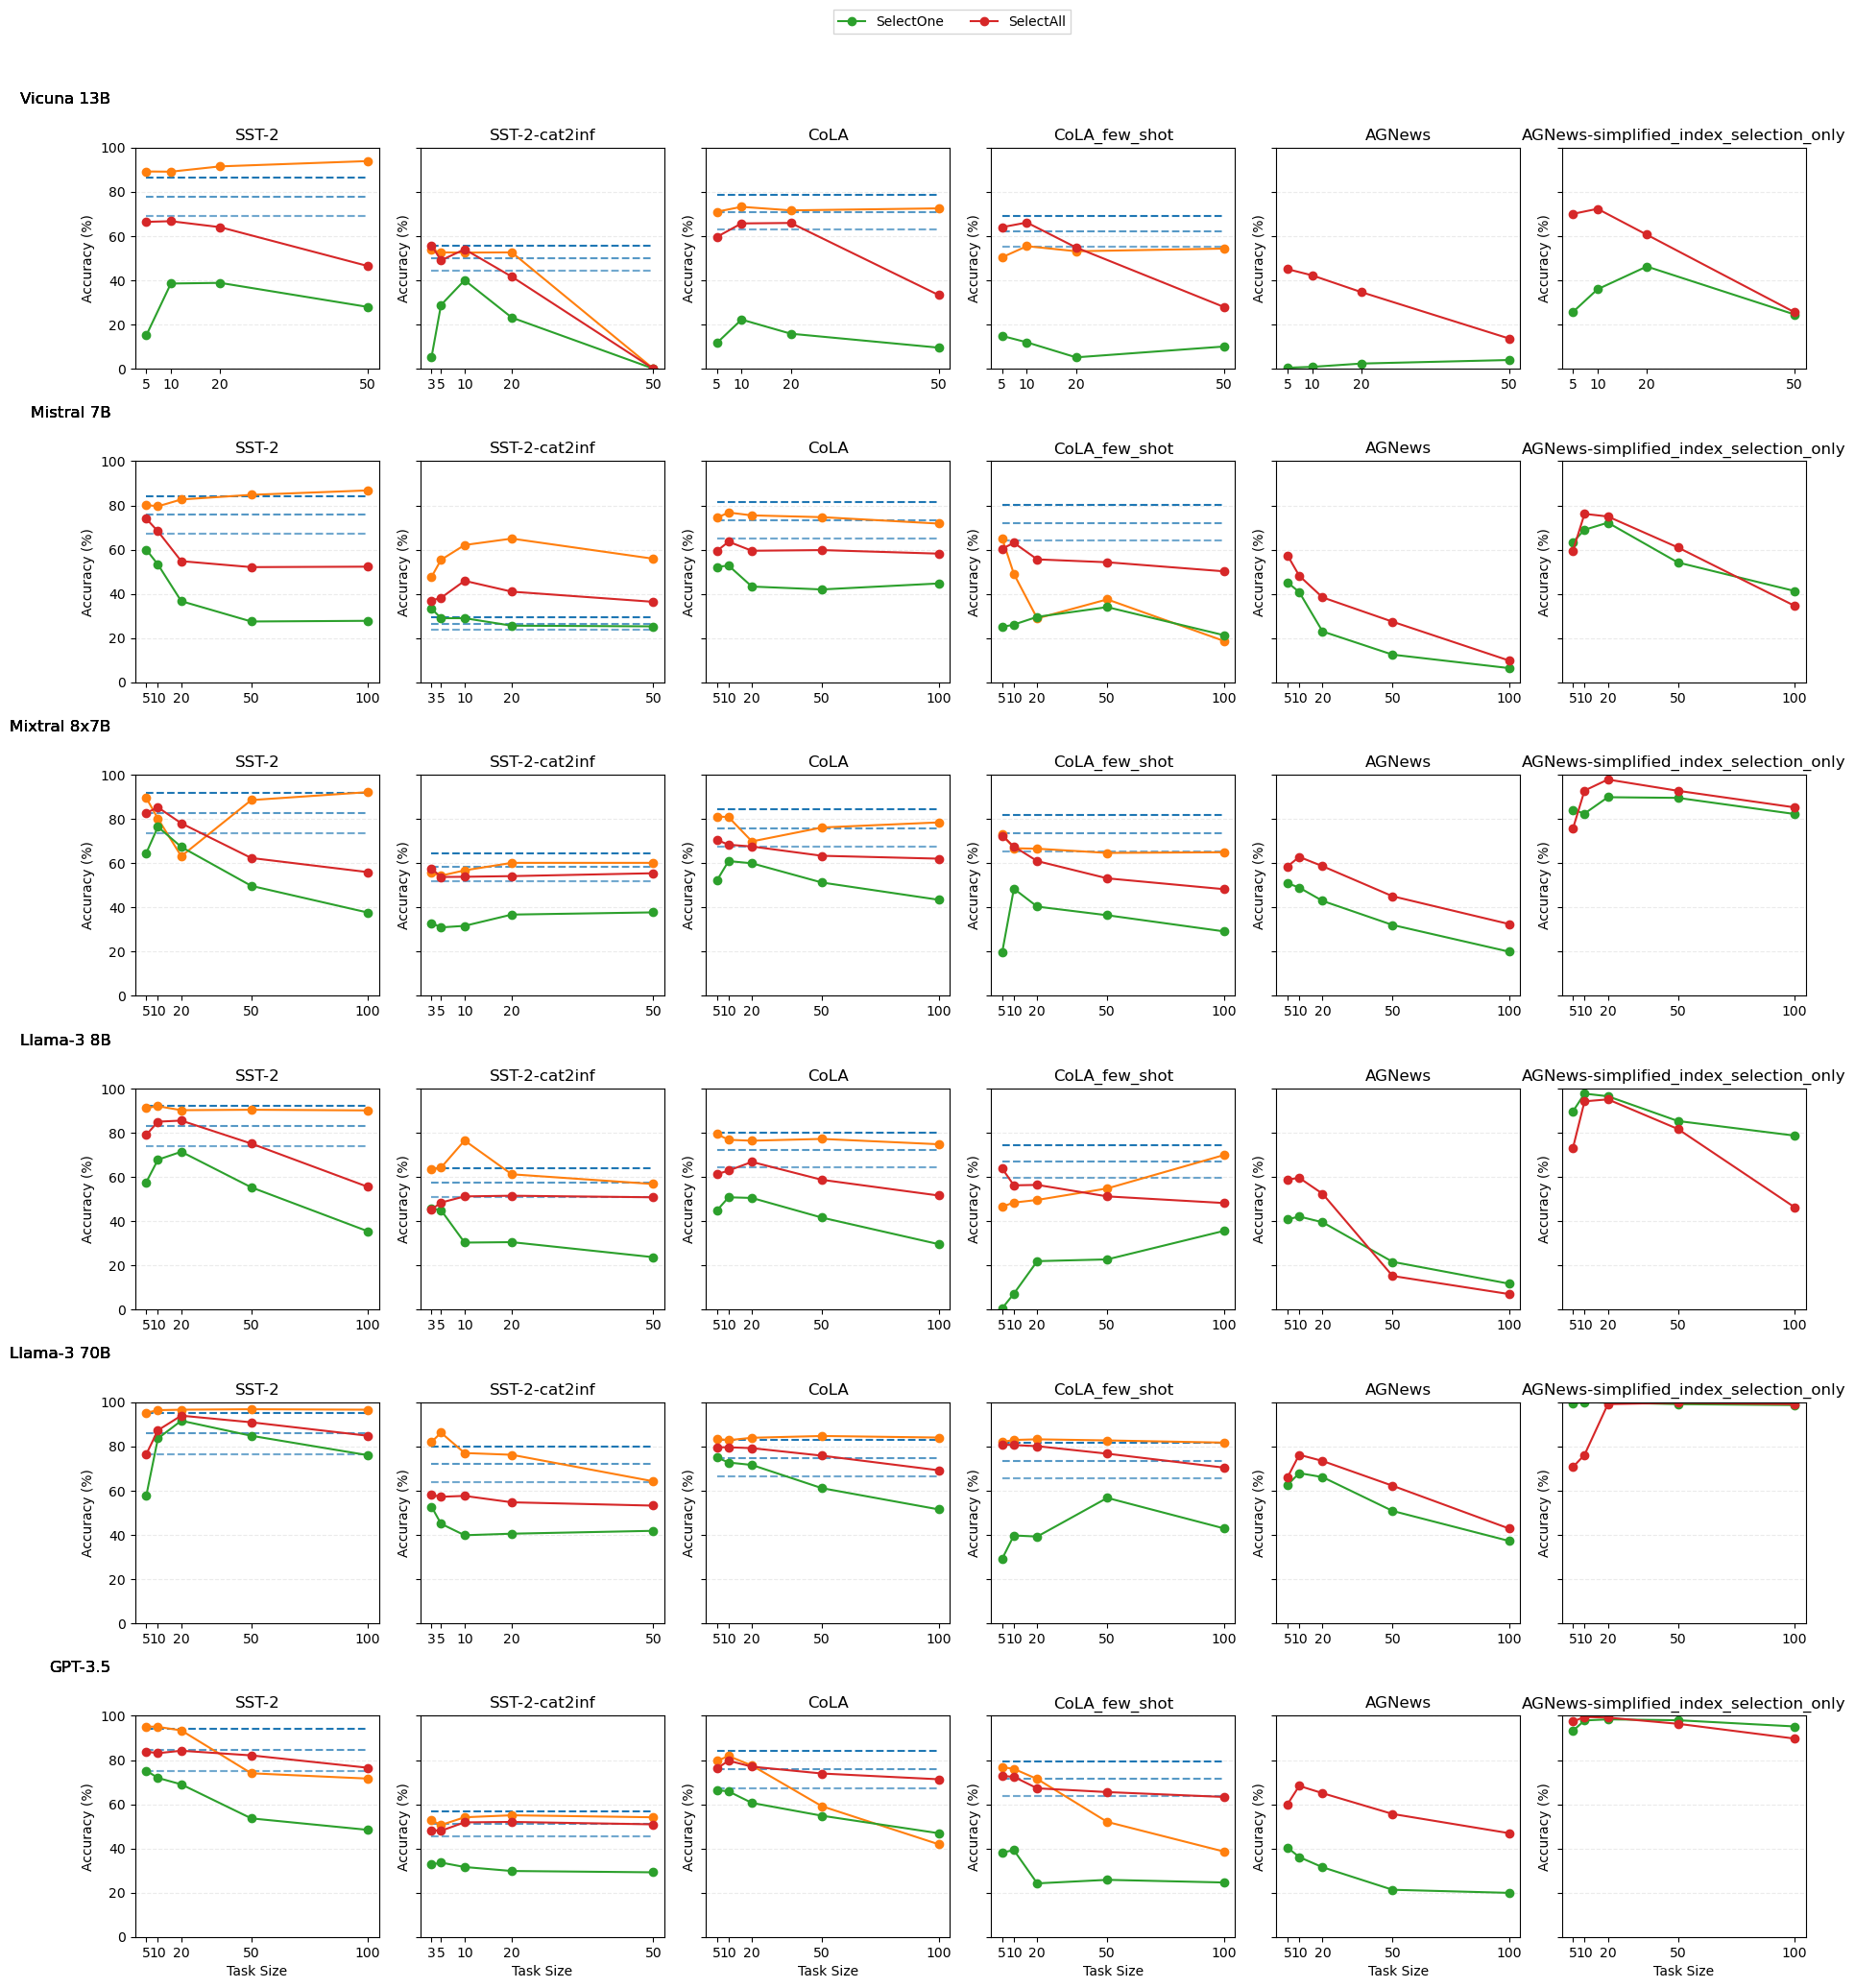

In [50]:
# # make a 1x6 grid plots, where each panel is a benchmark, with the taskSize on the x-axis and accuracy on the y-axis.

# task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", "SelectOne": "tab:green", "SelectAll": "tab:red"}

# fig, axs = plt.subplots(len(models), 6, figsize=(19, 21), sharey=True)
# models = ['Vicuna 13B', 'Mistral 7B', 'Mixtral 8x7B', 'Llama-3 8B', 'Llama-3 70B', 'GPT-3.5']

# prp_df["accuracy"] = prp_df.performance
# benchmarks = ["SST-2", "SST-2-cat2inf", "CoLA", "CoLA_few_shot", 
#               "AGNews", "AGNews-simplified_index_selection_only"]
              
# for j, model in enumerate(models):
#     for i, benchmark in enumerate(benchmarks):
#         sub = prp_df[(prp_df.benchmark == benchmark) & (prp_df.model == model)]
        
#         if "AGNews" not in benchmark:
#             taskSizes = sorted(sub.taskSize.unique())[1:]
#         else:
#             taskSizes = sorted(sub.taskSize.unique())

#         ax = axs[j][i]
#         for task in tasks:
#             subsub = sub[sub.task == task]

#             if task == "SingleClf":
#                 acc = subsub.accuracy
#                 ax.plot(taskSizes, [round(acc, 3) * 100]*len(taskSizes), label=task, linestyle="--", color=task2color[task])
#                 ax.plot(taskSizes, [round(acc * 0.90, 3) * 100] * len(taskSizes), label=f"90% {task} Acc", 
#                         linestyle="--", color=task2color[task], alpha=0.75)
#                 ax.plot(taskSizes, [round(acc * 0.80, 3) * 100] * len(taskSizes), label=f"80% {task} Acc", 
#                         linestyle="--", color=task2color[task], alpha=0.5)
                
#                 ax.plot(taskSizes, [round(acc * 0.80, 3) * 100] * len(taskSizes), label=f"75% {task} Acc", 
#                         linestyle="--", color=task2color[task], alpha=0.25)

#                 # random_baseline = prp_df[(prp_df.model == "Random Baseline") & (prp_df.benchmark == benchmark)].performance.mean()
#                 # ax.plot(taskSizes, [round(random_baseline, 3) * 100]*len(taskSizes), label="Random Baseline", linestyle="--", color="tab:gray")
#             else:
#                 accs = []
#                 for taskSize in taskSizes:
#                     acc = subsub[subsub.taskSize == taskSize].accuracy
#                     accs.append(round(acc, 3) * 100)
                    
#                 ax.plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])
            
#             ax.set_title(benchmark)
#             # if j == 0:
#             #    ax.set_title(benchmark)

#             if i == 0:
#                 ax.text(-0.1, 1.25, model, transform=ax.transAxes, 
#                         fontsize=12, va='top', ha='right')

#             if j == len(models) - 1:
#                 ax.set_xlabel("Task Size")
#             ax.set_xticks(taskSizes)
#             ax.set_ylabel("Accuracy (%)")
#             ax.set_yticks(np.arange(0, 101, 20))
#             ax.grid(axis='y', linestyle='--', alpha=0.25)
#             # axs[i].legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
#             ax.set_ylim(0, 100)

#             # if j == 3 and i == 5:
#             #     ax.legend(title="Task", loc='center left', bbox_to_anchor=(1.05, 0.5))

# # plt.suptitle("Average accuracy of the 7 LLMs on different tasks and task sizes")
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# # plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='upper center', bbox_to_anchor=(-2.5, 8.75), fancybox=False, shadow=False, ncol=7)

# # plt.savefig("plots/full_results_follow_up.png", bbox_inches='tight', dpi=300)
# plt.show()

## Cat2Inf

In [145]:
benchmarks = ["SST-2-cat2inf"]
models = ['meta-llama/Llama-3-70b-chat-hf', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5-turbo-0125',
          'meta-llama/Llama-3-8b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.2', 'lmsys/vicuna-13b-v1.5', 
          "gpt-4-turbo-2024-04-09"]
tasks = ["single_clf", "batch_clf", "index_selection_one_cat_a_time", "index_selection_all_cat_at_once"]

prp_df_3, evaled_df_3 = get_parse_rate_and_performance(benchmarks, models, tasks, return_evaluated_df=True)

In [146]:
task_renamer = {"single_clf": "SingleClf", "batch_clf": "BatchClf", 
                "index_selection_one_cat_a_time": "SelectOne", 
                "index_selection_all_cat_at_once": "SelectAll"}
prp_df_3.model = prp_df_3.model.map(model_renamer)
prp_df_3.task = prp_df_3.task.map(task_renamer)

In [147]:
models = ['Vicuna', 'Mistral 7B', 'Mixtral 8x7B', 'Llama-3 8B', 'Llama-3 70B', 'GPT-3.5', "GPT-4"]

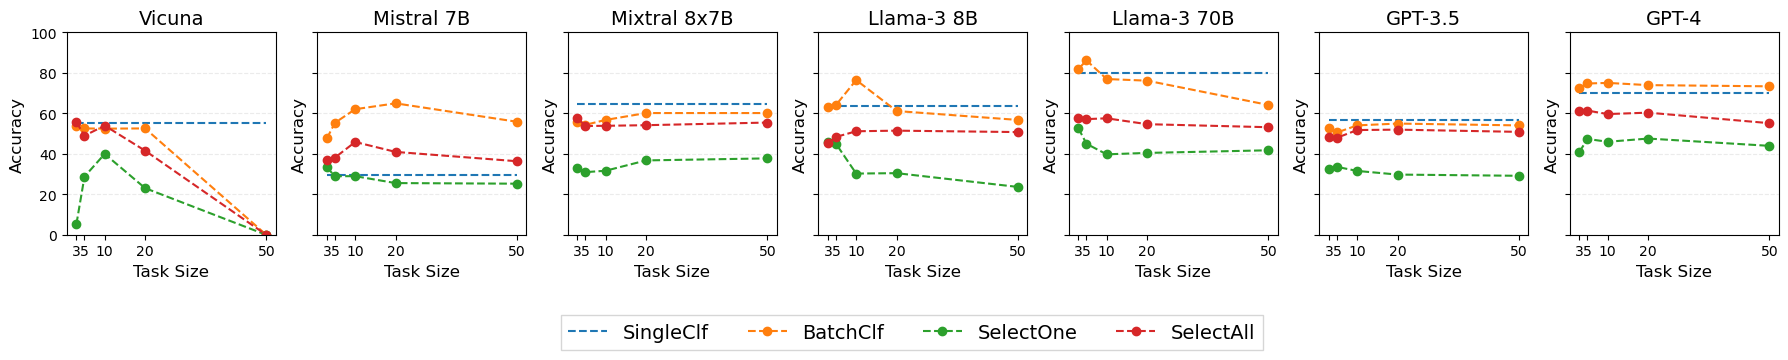

In [148]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 7, figsize=(18, 3), sharey=True)
tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]
task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
              "SelectOne": "tab:green", "SelectAll": "tab:red"}


for i, model in enumerate(models):
    sub = prp_df_3.copy()[prp_df_3.model == model]
    ax = axs[i]
    taskSizes = sorted(sub.taskSize.unique())[1:]
    num_sizes = len(taskSizes)

    for task in tasks:
        subsub = sub.copy()[sub.task == task]
        
        if task == "SingleClf":
            acc = round(subsub["performance"].mean(), 3) * 100
            ax.plot(taskSizes, [acc] * num_sizes, label=task, linestyle="--", color=task2color[task])
            
        else:
            accus = []
            for taskSize in taskSizes:
                subsubsub = subsub.copy()[subsub.taskSize == taskSize]
                acc = subsubsub["performance"].mean()
                accus.append(round(acc, 3) * 100)

            ax.plot(taskSizes, accus, label=task, marker='o', linestyle="--", color=task2color[task])

    ax.set_title(model, fontsize=14)
    ax.set_xlabel("Task Size", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    
    ax.set_ylim(0, 100)
    ax.set_xticks(taskSizes)
    
plt.tight_layout()
# plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(-3.15, -0.35), fancybox=False, shadow=False, ncol=4, fontsize=14)
plt.savefig("plots/sst-2-inf-results.png",  bbox_inches='tight', dpi=300)
plt.show()

In [149]:
prp_df_3[prp_df_3.task == "SingleClf"]

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance
0,SST-2-cat2inf,SingleClf,1,Random Baseline,-,0.52,NaN,NaN
1,SST-2-cat2inf,SingleClf,1,Llama-3 70B,False,0.00,1.000,0.800
2,SST-2-cat2inf,SingleClf,1,Mixtral 8x7B,False,0.00,0.968,0.647
3,SST-2-cat2inf,SingleClf,1,GPT-3.5,False,0.00,1.000,0.567
4,SST-2-cat2inf,SingleClf,1,Llama-3 8B,False,0.00,0.988,0.638
5,SST-2-cat2inf,SingleClf,1,Mistral 7B,False,0.00,0.376,0.296
6,SST-2-cat2inf,SingleClf,1,Vicuna,False,0.00,1.000,0.555
7,SST-2-cat2inf,SingleClf,1,GPT-4,False,0.00,1.000,0.701


In [62]:
benchmarks = ["CoLA_few_shot", "CoLA"]
models = ['meta-llama/Llama-3-70b-chat-hf', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5-turbo-0125',
          'meta-llama/Llama-3-8b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.2', 'lmsys/vicuna-13b-v1.5', 
          "gpt-4-turbo-2024-04-09"]
tasks = ["single_clf", "batch_clf", "index_selection_one_cat_a_time", 
         "index_selection_all_cat_at_once", "index_selection_all_cat_at_once_adjusted"]

In [63]:
prp_df_CoLA, evaled_df_CoLA = get_parse_rate_and_performance(benchmarks, models, tasks, CoT=[False], return_evaluated_df=True)

In [64]:
task_renamer = {"single_clf": "SingleClf", "batch_clf": "BatchClf", 
                "index_selection_one_cat_a_time": "SelectOne", 
                "index_selection_all_cat_at_once": "SelectAll"}
model_renamer = {"meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
                 "gpt-3.5-turbo-0125": "GPT-3.5", "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
                 "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", "gpt-4-turbo-2024-04-09": "GPT-4", 
                 "lmsys/vicuna-13b-v1.5": "Vicuna", "random baseline": "Random Baseline"}

prp_df_CoLA.model = prp_df_CoLA.model.map(model_renamer)
prp_df_CoLA.task = prp_df_CoLA.task.map(task_renamer)
prp_df_adjusted = prp_df_CoLA.copy()

In [77]:
sub_5 = prp_df_adjusted.copy()[(prp_df_adjusted.taskSize <= 5) & (prp_df_adjusted.model != "Random Baseline")]
tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]

overall = []
for benchmark in ["CoLA_few_shot", "CoLA"]:
    subsub = sub_5.copy()[sub_5.benchmark == benchmark]
    for task in ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]:
        subsubsub = subsub[subsub.task == task]
        performance = subsubsub.performance.mean()
        taskSize = int(subsubsub.taskSize.mean())

        overall.append([benchmark, task, taskSize, "Overall", False, 0, "-", performance])

sub_5 = pd.concat([sub_5, pd.DataFrame(overall, columns=sub_5.columns)]).reset_index(drop=True)
sub_5_pivot = sub_5.pivot(index=["model", "benchmark"], columns="task", values="performance")[tasks].round(3)*100

In [78]:
print(sub_5_pivot.to_latex())

\begin{tabular}{llrrrr}
\toprule
       & task &  SingleClf &  BatchClf &  SelectOne &  SelectAll \\
model & benchmark &            &           &            &            \\
\midrule
GPT-3.5 & CoLA &       84.2 &      79.6 &       63.4 &       76.2 \\
       & CoLA\_few\_shot &       79.5 &      76.8 &       38.2 &       72.8 \\
GPT-4 & CoLA &       85.1 &      83.8 &       77.8 &       83.6 \\
       & CoLA\_few\_shot &       85.7 &      80.8 &       48.6 &       81.0 \\
Llama-3 70B & CoLA &       82.8 &      83.4 &       71.2 &       79.6 \\
       & CoLA\_few\_shot &       81.8 &      82.0 &       29.2 &       80.8 \\
Llama-3 8B & CoLA &       80.2 &      79.4 &       33.4 &       61.2 \\
       & CoLA\_few\_shot &       74.3 &      46.6 &        0.6 &       63.8 \\
Mistral 7B & CoLA &       81.5 &      74.4 &       47.4 &       59.4 \\
       & CoLA\_few\_shot &       80.2 &      65.0 &       25.0 &       60.4 \\
Mixtral 8x7B & CoLA &       84.4 &      81.2 &       65.0 &       70.6

/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_34485/2551405612.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sub_5_pivot.to_latex())


In [15]:
main_results = []
cols = ["benchmark", "task", "taskSize", "accuracy"]
tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]
benchmarks = ["CoLA_few_shot", "CoLA"]

for benchmark in benchmarks:
    sub = prp_df_adjusted.copy()[prp_df_adjusted.benchmark == benchmark]
    for task in tasks:
        subsub = sub.copy()[sub.task == task]
        for taskSize in sorted(subsub.taskSize.unique()):
            subsubsub = subsub.copy()[subsub.taskSize == taskSize]
            acc = subsubsub["performance"].mean()
            main_results.append([benchmark, task, taskSize, acc])

# benchmarks = names[:1] + names[-1:] + benchmarks[:3] + benchmarks[3:]
main_results_df = pd.DataFrame(main_results, columns=cols)
main_results_df_pv = main_results_df.pivot(index=["benchmark", "taskSize"], columns="task", values="accuracy")
main_results_df_pv = main_results_df_pv.loc[benchmarks]
main_results_df_pv = main_results_df_pv.round(3)
main_results_df_pv = main_results_df_pv * 100
main_results_df_pv = main_results_df_pv.astype(float)
main_results_df_pv[tasks]

task                    SingleClf  BatchClf  SelectOne  SelectAll
benchmark     taskSize                                           
CoLA_few_shot 1              78.9       NaN        NaN        NaN
              5               NaN      67.8       18.2       59.2
              10              NaN      65.7       24.7       58.0
              20              NaN      62.2       22.9       53.6
              50              NaN      61.3       26.5       47.0
              100             NaN      51.7       22.7       42.3
CoLA          1              82.4       NaN        NaN        NaN
              5               NaN      79.0       58.1       70.0
              10              NaN      79.5       59.0       72.0
              20              NaN      77.0       54.3       71.4
              50              NaN      75.6       45.5       64.1
              100             NaN      71.9       43.5       61.0

In [16]:
models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]
models

['Vicuna',
 'Mistral 7B',
 'Mixtral 8x7B',
 'Llama-3 8B',
 'Llama-3 70B',
 'GPT-3.5',
 'GPT-4']

In [18]:
# prp_df_adjusted_sub = prp_df_adjusted.copy()[(prp_df_adjusted.taskSize <= 5) & (prp_df_adjusted.model != "Random Baseline")]
# few_shot_res = prp_df_adjusted_sub.pivot(index=["model"], columns="task", values="performance")[tasks].round(3) * 100
# few_shot_res

In [28]:
print(few_shot_res.to_latex())

\begin{tabular}{lrrrr}
\toprule
task &  SingleClf &  BatchClf &  SelectOne &  SelectAll \\
model        &            &           &            &            \\
\midrule
GPT-3.5      &       79.5 &      76.8 &       38.2 &       72.8 \\
Llama-3 70B  &       81.8 &      82.0 &       29.2 &       80.8 \\
Llama-3 8B   &       74.3 &      46.6 &        0.6 &       63.8 \\
Mistral 7B   &       80.2 &      65.0 &       25.0 &       60.4 \\
Mixtral 8x7B &       81.8 &      73.2 &       19.8 &       72.4 \\
Vicuna       &       69.0 &      50.4 &       14.8 &       64.0 \\
\bottomrule
\end{tabular}



/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_5489/2968654569.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(few_shot_res.to_latex())


In [19]:
models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

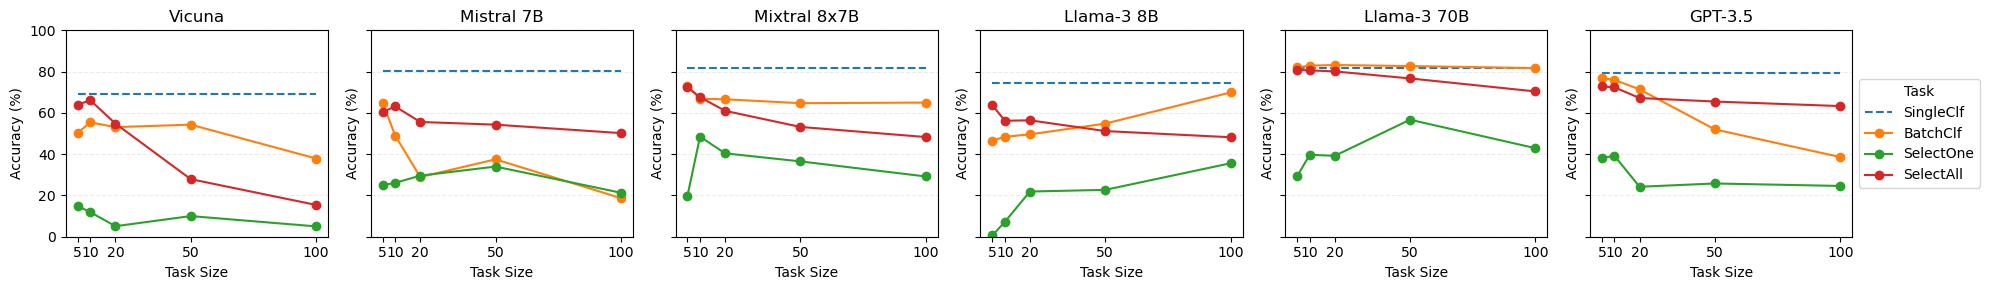

In [55]:
fig, axs = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
              "SelectOne": "tab:green", "SelectAll": "tab:red"}

for i, model in enumerate(models):
    ax = axs[i]
    sub = prp_df_CoLA.copy()[prp_df_CoLA.model == model]
    taskSizes = sorted(sub.taskSize.unique())[1:]

    for task in tasks:
        subsub = sub.copy()[sub.task == task]

        if task == "SingleClf":
            acc = subsub.performance
            axs[i].plot(taskSizes, [round(acc, 3) * 100] * len(taskSizes), label=task, linestyle="--", color=task2color[task])
        else:
            accs = []
            for taskSize in taskSizes:
                acc = subsub[subsub.taskSize == taskSize].performance
                accs.append(round(acc, 3) * 100)
            
            ax.plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])

    ax.set_title(model)
    ax.set_ylim(0, 100)
    ax.set_xticks(taskSizes)
    ax.set_xlabel("Task Size")
    ax.set_ylabel("Accuracy (%)")
    ax.grid(axis='y', linestyle='--', alpha=0.25)

plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("plots/cola-few-shot-results.png", dpi=300)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3), sharey=True)
task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
              "SelectOne": "tab:green", "SelectAll": "tab:red"}

for i, model in enumerate(models):
    ax = axs[i]
    sub = prp_df_CoLA.copy()[prp_df_CoLA.model == model]
    taskSizes = sorted(sub.taskSize.unique())[1:]

    for task in tasks:
        subsub = sub.copy()[sub.task == task]

        if task == "SingleClf":
            acc = subsub.performance
            axs[i].plot(taskSizes, [round(acc, 3) * 100] * len(taskSizes), label=task, linestyle="--", color=task2color[task])
        else:
            accs = []
            for taskSize in taskSizes:
                acc = subsub[subsub.taskSize == taskSize].performance
                accs.append(round(acc, 3) * 100)
            
            ax.plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])

    ax.set_title(model)
    ax.set_ylim(0, 100)
    ax.set_xticks(taskSizes)
    ax.set_xlabel("Task Size")
    ax.set_ylabel("Accuracy (%)")
    ax.grid(axis='y', linestyle='--', alpha=0.25)

plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("plots/cola-few-shot-results.png", dpi=300)

plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
#               "SelectOne": "tab:green", "SelectAll": "tab:red"}

# plt.figure(figsize=(3.5, 3))

# for benchmark in benchmarks:
#     for task in tasks:
#         sub = main_results_df.copy()[(main_results_df.benchmark == benchmark) & (main_results_df.task == task)]

#         if len(sub) == 0:
#             continue

#         taskSizes = sorted(sub.taskSize.unique())

#         accus = []
#         for taskSize in taskSizes:
#             subsub = sub.copy()[sub.taskSize == taskSize]
#             acc = subsub["accuracy"].values[0]
#             accus.append(round(acc, 3) * 100)
        
#         if "Simplified" in benchmark:
#             suffix = " Simplified"
#             marker = 'x'
#         else:
#             suffix = ""
#             marker = 'o'
#         plt.plot(taskSizes, accus, label=task+suffix, marker=marker, color=task2color[task])

# plt.ylim(0, 100)
# plt.xticks(taskSizes)
# plt.xlabel("Task Size")
# plt.ylabel("Accuracy (%)")
# plt.legend(fontsize=5)
# plt.grid(axis='y', linestyle='--', alpha=0.25)
# plt.tight_layout()
# # plt.savefig("plots/simplified-index-selection-results.png", dpi=300)
# plt.show()